In [224]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import pandas as pd
from itertools import combinations
import random



In [225]:
tickers_1m = {
    "SOL_1m"  : "../Data/1m_Data/SOL_USDC_USDC_1m.csv",
    "ETH_1m"  : "../Data/1m_Data/ETH_USDC_USDC_1m.csv",
    "BTC_1m"  : "../Data/1m_Data/BTC_USDC_USDC_1m.csv",
    "AVAX_1m" : "../Data/1m_Data/AVAX_USDC_USDC_1m.csv",
    "NEAR_1m" : "../Data/1m_Data/NEAR_USDC_USDC_1m.csv",
    "OP_1m"   : "../Data/1m_Data/OP_USDC_USDC_1m.csv",
    "ARB_1m"  : "../Data/1m_Data/ARB_USDC_USDC_1m.csv",
    "LDO_1m"  : "../Data/1m_Data/LDO_USDC_USDC_1m.csv",
    "LINK_1m" : "../Data/1m_Data/LINK_USDC_USDC_1m.csv",
    "AAVE_1m" : "../Data/1m_Data/AAVE_USDC_USDC_1m.csv"
}


tickers_3m = {
    "SOL_3m"  : "../Data/3m_Data/SOL_USDC_USDC_3m.csv",
    "ETH_3m"  : "../Data/3m_Data/ETH_USDC_USDC_3m.csv",
    "BTC_3m"  : "../Data/3m_Data/BTC_USDC_USDC_3m.csv",
    "AVAX_3m" : "../Data/3m_Data/AVAX_USDC_USDC_3m.csv",
    "NEAR_3m" : "../Data/3m_Data/NEAR_USDC_USDC_3m.csv",
    "OP_3m"   : "../Data/3m_Data/OP_USDC_USDC_3m.csv",
    "ARB_3m"  : "../Data/3m_Data/ARB_USDC_USDC_3m.csv",
    "LDO_3m"  : "../Data/3m_Data/LDO_USDC_USDC_3m.csv",
    "LINK_3m" : "../Data/3m_Data/LINK_USDC_USDC_3m.csv",
    "AAVE_3m" : "../Data/3m_Data/AAVE_USDC_USDC_3m.csv"
}


tickers_5m = {
    "SOL_5m"  : "../Data/5m_Data/SOL_USDC_USDC_5m.csv",
    "ETH_5m"  : "../Data/5m_Data/ETH_USDC_USDC_5m.csv",
    "BTC_5m"  : "../Data/5m_Data/BTC_USDC_USDC_5m.csv",
    "AVAX_5m" : "../Data/5m_Data/AVAX_USDC_USDC_5m.csv",
    "NEAR_5m" : "../Data/5m_Data/NEAR_USDC_USDC_5m.csv",
    "OP_5m"   : "../Data/5m_Data/OP_USDC_USDC_5m.csv",
    "ARB_5m"  : "../Data/5m_Data/ARB_USDC_USDC_5m.csv",
    "LDO_5m"  : "../Data/5m_Data/LDO_USDC_USDC_5m.csv",
    "LINK_5m" : "../Data/5m_Data/LINK_USDC_USDC_5m.csv",
    "AAVE_5m" : "../Data/5m_Data/AAVE_USDC_USDC_5m.csv"
}


tickers_15m = {
    "SOL_15m"  : "../Data/15m_Data/SOL_USDC_USDC_15m.csv",
    "ETH_15m"  : "../Data/15m_Data/ETH_USDC_USDC_15m.csv",
    "BTC_15m"  : "../Data/15m_Data/BTC_USDC_USDC_15m.csv",
    "AVAX_15m" : "../Data/15m_Data/AVAX_USDC_USDC_15m.csv",
    "NEAR_15m" : "../Data/15m_Data/NEAR_USDC_USDC_15m.csv",
    "OP_15m"   : "../Data/15m_Data/OP_USDC_USDC_15m.csv",
    "ARB_15m"  : "../Data/15m_Data/ARB_USDC_USDC_15m.csv",
    "LDO_15m"  : "../Data/15m_Data/LDO_USDC_USDC_15m.csv",
    "LINK_15m" : "../Data/15m_Data/LINK_USDC_USDC_15m.csv",
    "AAVE_15m" : "../Data/15m_Data/AAVE_USDC_USDC_15m.csv"
}

tickers_1h = {
    "SOL_1h"  : "../Data/1h_Data/SOL_USDC_USDC_1h.csv",
    "ETH_1h"  : "../Data/1h_Data/ETH_USDC_USDC_1h.csv",
    "BTC_1h"  : "../Data/1h_Data/BTC_USDC_USDC_1h.csv",
    "AVAX_1h" : "../Data/1h_Data/AVAX_USDC_USDC_1h.csv",
    "NEAR_1h" : "../Data/1h_Data/NEAR_USDC_USDC_1h.csv",
    "OP_1h"   : "../Data/1h_Data/OP_USDC_USDC_1h.csv",
    "ARB_1h"  : "../Data/1h_Data/ARB_USDC_USDC_1h.csv",
    "LDO_1h"  : "../Data/1h_Data/LDO_USDC_USDC_1h.csv",
    "LINK_1h" : "../Data/1h_Data/LINK_USDC_USDC_1h.csv",
    "AAVE_1h" : "../Data/1h_Data/AAVE_USDC_USDC_1h.csv"
}

tickers_4h = {
    "SOL_4h"  : "../Data/4h_Data/SOL_USDC_USDC_4h.csv",
    "ETH_4h"  : "../Data/4h_Data/ETH_USDC_USDC_4h.csv",
    "BTC_4h"  : "../Data/4h_Data/BTC_USDC_USDC_4h.csv",
    "AVAX_4h" : "../Data/4h_Data/AVAX_USDC_USDC_4h.csv",
    "NEAR_4h" : "../Data/4h_Data/NEAR_USDC_USDC_4h.csv",
    "OP_4h"   : "../Data/4h_Data/OP_USDC_USDC_4h.csv",
    "ARB_4h"  : "../Data/4h_Data/ARB_USDC_USDC_4h.csv",
    "LDO_4h"  : "../Data/4h_Data/LDO_USDC_USDC_4h.csv",
    "LINK_4h" : "../Data/4h_Data/LINK_USDC_USDC_4h.csv",
    "AAVE_4h" : "../Data/4h_Data/AAVE_USDC_USDC_4h.csv"
}





In [226]:
base_symbol = "ETH"
quote_symbol = "AVAX"
timeframe = "5m"

ticker_map = {
    "1m": tickers_1m,
    "3m": tickers_3m,
    "5m": tickers_5m,
    "15m": tickers_15m,
    "1h" : tickers_1h,
    "4h" : tickers_4h
}



base_df = pd.read_csv(ticker_map[timeframe][f"{base_symbol}_{timeframe}"])
quote_df = pd.read_csv(ticker_map[timeframe][f"{quote_symbol}_{timeframe}"])

base_close = base_df['close']
quote_close = quote_df['close']

In [227]:

base_close_series = base_close
quote_close_series = quote_close

shared_timestamps = base_close_series.index.intersection(quote_close_series.index)

base_price_aligned = base_close_series.loc[shared_timestamps]
quote_price_aligned = quote_close_series.loc[shared_timestamps]


first_axis = base_price_aligned.to_numpy()
second_axis = quote_price_aligned.to_numpy()


/var/folders/c_/_ctxnkln1z76h710t7sk2rk40000gn/T/ipykernel_81686/2723351006.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


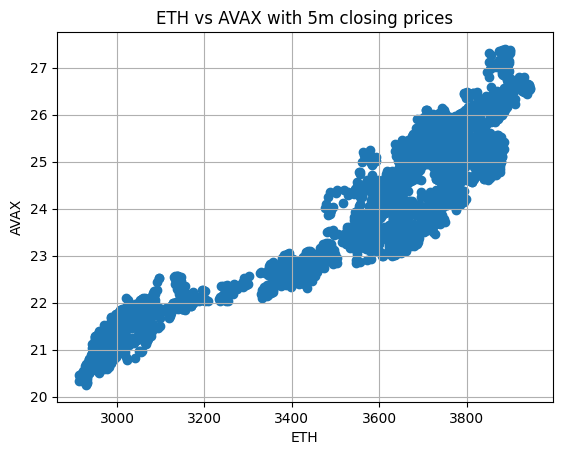

In [228]:
fig, ax = plt.subplots()
ax.scatter(first_axis,second_axis)
ax.set_xlabel(base_symbol)
ax.set_ylabel(quote_symbol)
ax.set_title(f"{base_symbol} vs {quote_symbol} with {timeframe} closing prices")
ax.grid(True)
fig.show()

<function matplotlib.pyplot.show(close=None, block=None)>

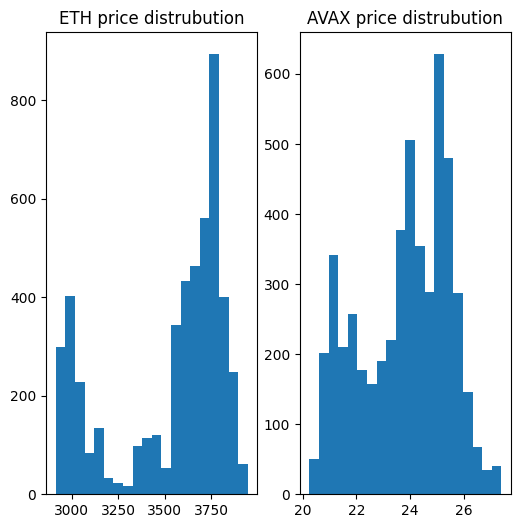

In [229]:
bins = 20

fig,(base_hist,quote_hist) = plt.subplots(nrows=1,ncols=2,figsize=(6,6))
base_hist.hist(first_axis,bins=bins)
base_hist.set_title(f"{base_symbol} price distrubution")

quote_hist.hist(second_axis,bins=bins)
quote_hist.set_title(f"{quote_symbol} price distrubution")

plt.show


In [230]:
price_matrix = np.column_stack(
    [first_axis,second_axis]
)
print(price_matrix.shape)




(5013, 2)


In [231]:

price_centered_matrix = price_matrix - price_matrix.mean(axis=0)
print(price_centered_matrix.shape)


(5013, 2)


In [232]:
covariance_matrix = np.cov(price_matrix,rowvar=False)
eigen_values, eigen_vectors = np.linalg.eigh(covariance_matrix)

print(np.array2string(covariance_matrix, formatter={'float_kind':lambda x: "%.10f" % x}))


[[93726.8768036600 474.9140134267]
 [474.9140134267 2.7218741637]]


In [233]:
U,Singular_Vals,V_Trans = np.linalg.svd(price_centered_matrix,full_matrices=False)

principal_vector_one = V_Trans[0]
principal_vector_two = V_Trans[1]

print(principal_vector_two)


[ 0.00506695 -0.99998716]


In [234]:
n = len(price_centered_matrix[:,0])

singular_vals_squared = [v**2 for v in Singular_Vals]

lambda_1 = singular_vals_squared[0] / (n-1)
lambda_2 = singular_vals_squared[1] / (n-1)

total_variance = lambda_1 + lambda_2
lambda_1_var = lambda_1/total_variance
lambda_2_var = lambda_2/total_variance

print(f"Total variance is {total_variance:.10f}")
print(f"lambda one explains {lambda_1_var * 100:.10f}%")
print(f"lambda two explains {lambda_2_var * 100:.10f}%")

Total variance is 93729.5986778238
lambda one explains 99.9996634178%
lambda two explains 0.0003365822%


In [235]:
residual_vector = price_centered_matrix @ principal_vector_two

print(residual_vector.shape)

(5013,)


In [236]:
result = adfuller(residual_vector)

adf_stat = result[0]
p_value = result[1]

used_lags = result[2]
n_obs = result[3]

critical_values = result[4]

print(f"ADF Statistic: {adf_stat:.10f}")
print(f"p-value: {p_value:.10f}")
print(f"Used Lags: {used_lags}")
print(f"Number of Observations: {n_obs}")
print("Critical Values:")
for key, value in critical_values.items():
       print(f"    {key}: {value}")



ADF Statistic: -3.1024322493
p-value: 0.0263737140
Used Lags: 6
Number of Observations: 5006
Critical Values:
    1%: -3.431656962913683
    5%: -2.862117536432845
    10%: -2.5670774233173486


The price is [2964.      21.042]
The mean is [3527.19858368   23.80432316]


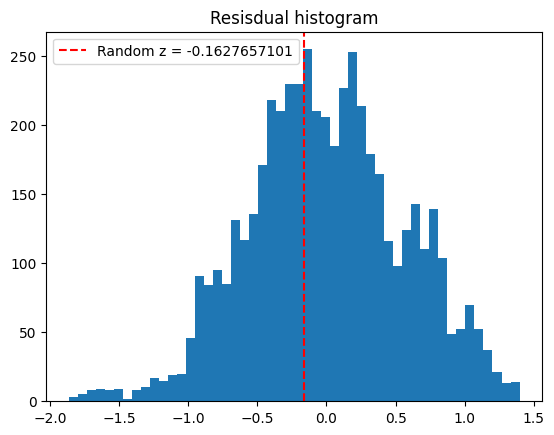

In [237]:
#graphing the histogram
bins = 50
fig,(base_hist) = plt.subplots()
base_hist.hist(residual_vector,bins=bins)
base_hist.set_title("Resisdual histogram")

#calculating z score with a random row from the price matrix
row_i = price_matrix[np.random.randint(price_matrix.shape[0])]
mean_vector = price_matrix.mean(axis=0)
residual_vector_std = residual_vector.std()
residual_mean = residual_vector.mean()
random_residual = (row_i - mean_vector) @ principal_vector_two
z_score = (random_residual - residual_mean) / residual_vector_std


# plotting the z-score
base_hist.axvline(z_score,color='red',linestyle="--",label=f'Random z = {z_score:.10f}')
base_hist.legend()


print(f"The price is {row_i}")
print(f"The mean is {mean_vector}")